In [2]:
# MAIN TODO:
#     - put validation set as early stopping DONE 
#     - show loss functions decrease through epochs (train, test and val) DONE 
#     - show correct and incorrect predictions DONE  
#     - can modify the layers DOING    
#     - put optuna to find best params
#     


# Imports

In [31]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions

In [32]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None


def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

# Setup

In [33]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                    ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [34]:
# # just to run fast
# subset_sample      = 1000

# train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
# validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
# test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


# Def MLP

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function):
        super(MLP, self).__init__()
        self.activation_function = activation_function

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))

        x = self.layers[-1](x)
        
        return x 

# Def hyperparameters and Loaders

In [42]:
input_size          = 32*32*3
num_classes         = 10
hidden_layers = [64, 64, 128, 128]

# TODO: let this params manipulated
learning_rate       = 0.001
num_epochs          = 100
batch_size          = 16
activation_function = nn.ReLU()

loss_function       = nn.CrossEntropyLoss()

In [43]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # to avoid bias
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Main training Loop

In [ ]:
mlp = MLP(input_size=input_size, hidden_layers=hidden_layers, num_classes=num_classes, activation_function=activation_function)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.SGD(mlp.parameters(), lr=learning_rate)

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // batch_size}, Loss: {loss}')

    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, validation_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break



  0%|          | 0/100 [00:02<?, ?it/s]

 Epoch 1/100, Step 1000/2500, Loss: 2.300208330154419


  0%|          | 0/100 [00:04<?, ?it/s]

 Epoch 1/100, Step 2000/2500, Loss: 2.3100011348724365


  1%|          | 1/100 [00:06<11:23,  6.90s/it]

Epoch 1:
Train Loss: 2.3009
Val Loss: 2.2978
Test Loss: 2.2981


  1%|          | 1/100 [00:08<11:23,  6.90s/it]

 Epoch 2/100, Step 1000/2500, Loss: 2.298199415206909


  1%|          | 1/100 [00:10<11:23,  6.90s/it]

 Epoch 2/100, Step 2000/2500, Loss: 2.2812230587005615


  2%|▏         | 2/100 [00:13<10:48,  6.62s/it]

Epoch 2:
Train Loss: 2.2942
Val Loss: 2.2890
Test Loss: 2.2889


  2%|▏         | 2/100 [00:15<10:48,  6.62s/it]

 Epoch 3/100, Step 1000/2500, Loss: 2.285132646560669


  2%|▏         | 2/100 [00:17<10:48,  6.62s/it]

 Epoch 3/100, Step 2000/2500, Loss: 2.2580535411834717


  3%|▎         | 3/100 [00:19<10:21,  6.41s/it]

Epoch 3:
Train Loss: 2.2789
Val Loss: 2.2642
Test Loss: 2.2635


  3%|▎         | 3/100 [00:21<10:21,  6.41s/it]

 Epoch 4/100, Step 1000/2500, Loss: 2.2422828674316406


  3%|▎         | 3/100 [00:23<10:21,  6.41s/it]

 Epoch 4/100, Step 2000/2500, Loss: 2.2109367847442627


  4%|▍         | 4/100 [00:26<10:25,  6.52s/it]

Epoch 4:
Train Loss: 2.2258
Val Loss: 2.1761
Test Loss: 2.1732


  4%|▍         | 4/100 [00:28<10:25,  6.52s/it]

 Epoch 5/100, Step 1000/2500, Loss: 2.0703275203704834


  4%|▍         | 4/100 [00:30<10:25,  6.52s/it]

 Epoch 5/100, Step 2000/2500, Loss: 2.11702561378479


  5%|▌         | 5/100 [00:32<10:11,  6.44s/it]

Epoch 5:
Train Loss: 2.1213
Val Loss: 2.0775
Test Loss: 2.0715


  5%|▌         | 5/100 [00:34<10:11,  6.44s/it]

 Epoch 6/100, Step 1000/2500, Loss: 2.0695672035217285


  5%|▌         | 5/100 [00:36<10:11,  6.44s/it]

 Epoch 6/100, Step 2000/2500, Loss: 2.0111773014068604


  6%|▌         | 6/100 [00:38<10:06,  6.45s/it]

Epoch 6:
Train Loss: 2.0363
Val Loss: 2.0028
Test Loss: 1.9968


  6%|▌         | 6/100 [00:41<10:06,  6.45s/it]

 Epoch 7/100, Step 1000/2500, Loss: 2.019928216934204


  6%|▌         | 6/100 [00:43<10:06,  6.45s/it]

 Epoch 7/100, Step 2000/2500, Loss: 2.0597469806671143


  7%|▋         | 7/100 [00:45<10:05,  6.51s/it]

Epoch 7:
Train Loss: 1.9716
Val Loss: 1.9444
Test Loss: 1.9394


  7%|▋         | 7/100 [00:47<10:05,  6.51s/it]

 Epoch 8/100, Step 1000/2500, Loss: 1.8203972578048706


  7%|▋         | 7/100 [00:49<10:05,  6.51s/it]

 Epoch 8/100, Step 2000/2500, Loss: 2.0292882919311523


  8%|▊         | 8/100 [00:51<09:39,  6.30s/it]

Epoch 8:
Train Loss: 1.9180
Val Loss: 1.8968
Test Loss: 1.8885


  8%|▊         | 8/100 [00:53<09:39,  6.30s/it]

 Epoch 9/100, Step 1000/2500, Loss: 1.852961540222168


  8%|▊         | 8/100 [00:55<09:39,  6.30s/it]

 Epoch 9/100, Step 2000/2500, Loss: 2.1530630588531494


  9%|▉         | 9/100 [00:58<09:47,  6.45s/it]

Epoch 9:
Train Loss: 1.8727
Val Loss: 1.8556
Test Loss: 1.8450


  9%|▉         | 9/100 [01:00<09:47,  6.45s/it]

 Epoch 10/100, Step 1000/2500, Loss: 1.8883081674575806


  9%|▉         | 9/100 [01:02<09:47,  6.45s/it]

 Epoch 10/100, Step 2000/2500, Loss: 1.6359777450561523


 10%|█         | 10/100 [01:04<09:47,  6.53s/it]

Epoch 10:
Train Loss: 1.8326
Val Loss: 1.8208
Test Loss: 1.8064


 10%|█         | 10/100 [01:06<09:47,  6.53s/it]

 Epoch 11/100, Step 1000/2500, Loss: 1.6112987995147705


 10%|█         | 10/100 [01:08<09:47,  6.53s/it]

 Epoch 11/100, Step 2000/2500, Loss: 1.7847028970718384


 11%|█         | 11/100 [01:11<09:33,  6.45s/it]

Epoch 11:
Train Loss: 1.7945
Val Loss: 1.7869
Test Loss: 1.7706


# Evaluate best model

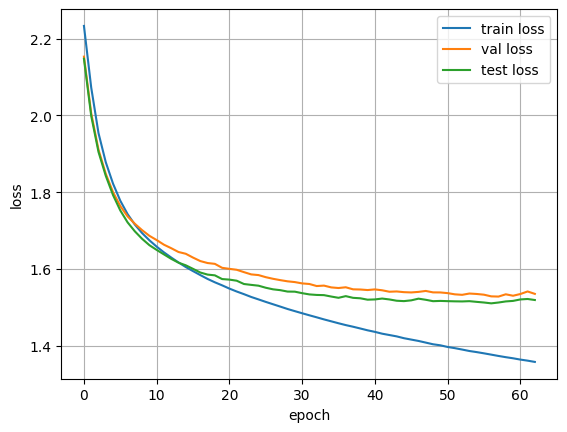

In [39]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

/tmp/ipykernel_21046/3695224772.py:87: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(h_pad=2)


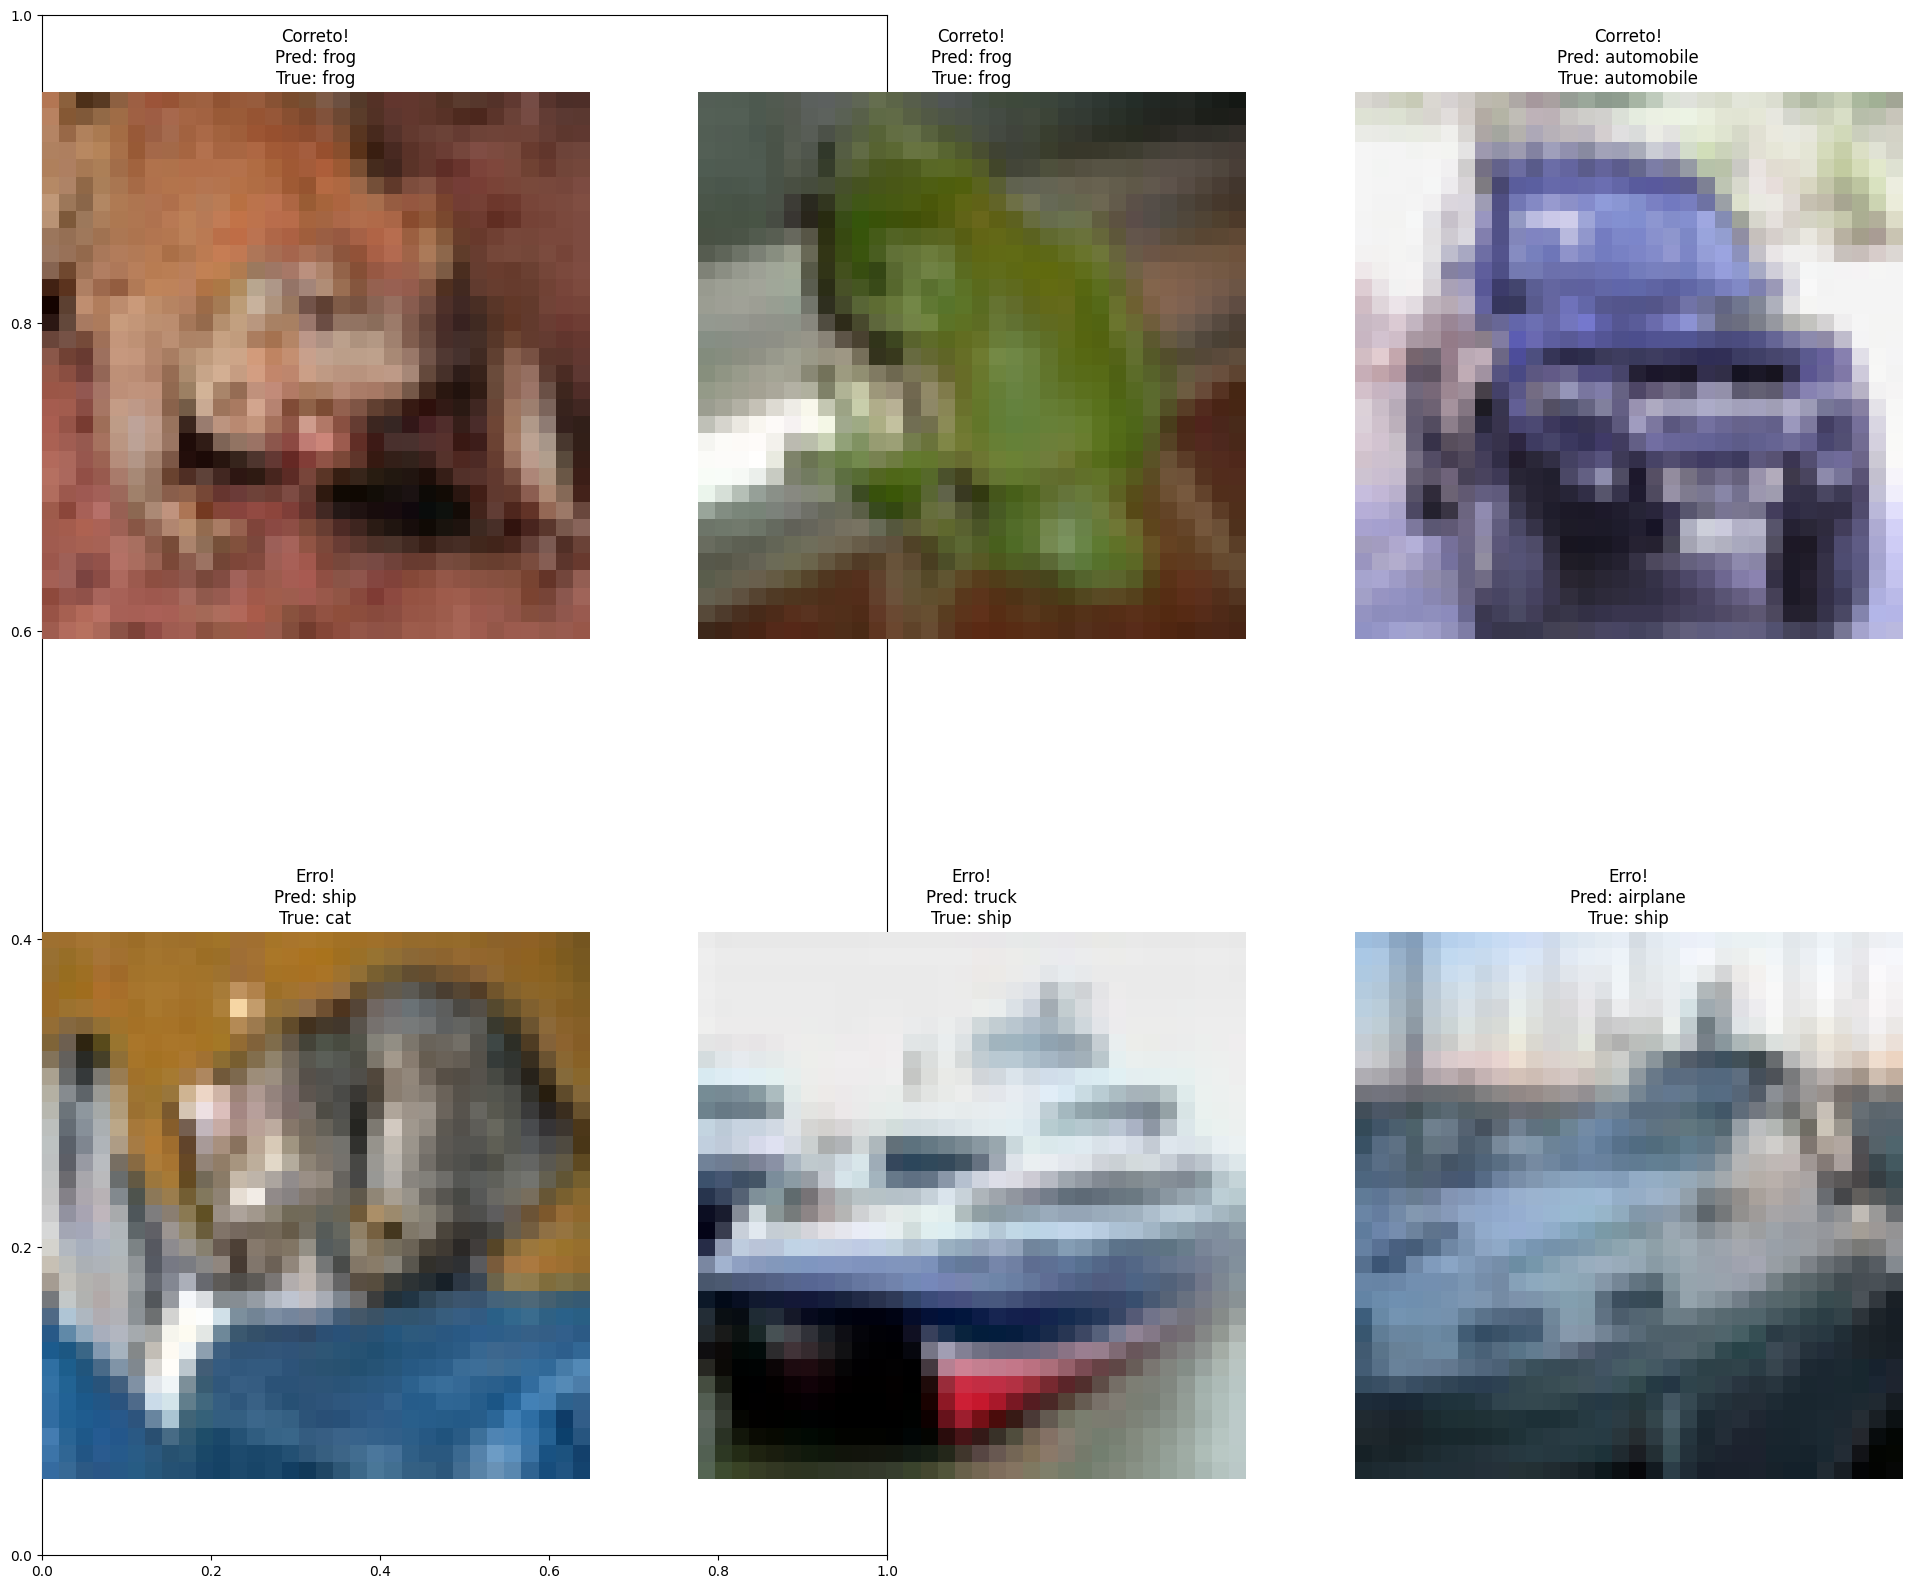

In [40]:
show_predictions(mlp, test_loader, num_samples=3)

In [ ]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.4632, 'balanced_accuracy': np.float64(0.46319999999999995), 'f1_score': 0.4573939757817296, 'precision': 0.4579577244110069, 'recall': 0.4632}


